In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np

import torchvision.utils as vutils

In [68]:
class Discriminator(nn.Module):
  def __init__(self, channels_img, features_d):
    super(Discriminator, self).__init__()
    self.disc = nn.Sequential(
        #input: N x channels_img x 64 x 64
        nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
        nn.LeakyReLU(0.2),

        #self._block(self, in_channels, out_channels, kernel_size, stride, padding)
        self._block(features_d, features_d * 2, 4, 2, 1),
        self._block(features_d * 2, features_d * 4, 4, 2, 1),
        self._block(features_d * 4, features_d * 8, 4, 2, 1),

        #After all _block image size is 4x4 (convolution below make it into a 1x1)
        nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        nn.Sigmoid()
    )


  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.Conv2d(
          in_channels,
          out_channels,
          kernel_size,
          stride,
          padding,
          bias=False
        ),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)   
      )
    
  def forward(self, x):
    return self.disc(x)

In [69]:
class Generator(nn.Module):
  def __init__(self,  z_dim, channels_img, features_g):
    super(Generator, self).__init__()
    self.gen = nn.Sequential(
        #input: N x z_dim x 1 X 1
        #self._block(self, in_channels, out_channels, kernel_size, stride, padding)
        self._block(z_dim, features_g * 16, 4, 1, 0),
        self._block(features_g * 16, features_g * 8, 4, 2, 1),
        self._block(features_g * 8, features_g * 4, 4, 2, 1),
        self._block(features_g * 4, features_g * 2, 4, 2, 1),

        nn.ConvTranspose2d(features_g * 2, channels_img, kernel_size=4, stride=2, padding=1),

        #Output: img N x channels_img x 64 x 64

        nn.Tanh() #[-1, 1]
    )


  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
      nn.ConvTranspose2d(
        in_channels,
        out_channels,
        kernel_size,
        stride,
        padding,
        bias=False
      ),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()   
  )
    
  def forward(self, x):
    return self.gen(x)

In [70]:
#initialize weights according to the DC GAN paper

def initialize_weights(model):
  for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
      nn.init.normal_(m.weight.data, 0.0, 0.02)

In [71]:
def test():
  N, in_channels, H, W = 8, 3, 64, 64
  z_dim = 100
  x = torch.randn((N, in_channels, H, W))

  disc = Discriminator(in_channels, 8)
  initialize_weights(disc)
  assert disc(x).shape == (N, 1, 1, 1), "Discriminator test failed"
  print("Discriminator test successfull")

  gen = Generator(z_dim, in_channels, 8)
  initialize_weights(gen)
  z = torch.randn((N, z_dim, 1, 1))
  assert gen(z).shape == (N, in_channels, H, W), "Generator test failed"
  print("Generator test successfull")
  print("Test succesfull")

In [72]:
test()

Discriminator test successfull
Generator test successfull
Test succesfull


In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [74]:
device

device(type='cuda')

In [94]:
LEARNING_RATE_GEN = 2e-4  # could also use two lrs, one for gen and one for disc
LEARNING_RATE_DISC = 2e-3 
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 1
Z_DIM = 100
NUM_EPOCHS = 5
FEATURES_DISC = 64
FEATURES_GEN = 64

In [95]:
print("Generator learning rate:", LEARNING_RATE_GEN)
print("Discriminator learning rate:", LEARNING_RATE_DISC)

Generator learning rate: 0.0002
Discriminator learning rate: 0.002


In [96]:
transform = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)])
    ]
)

In [97]:
dataset = datasets.MNIST(root="dataset/", train=True, transform = transform, download=True)

# comment mnist above and uncomment below if train on CelebA
#dataset = datasets.ImageFolder(root="celeb_dataset", transform=transforms)

In [98]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [99]:
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC)
gen.to(device)
disc.to(device)

Discriminator(
  (disc): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
    (6): Sigmoid()
  )
)

In [100]:
initialize_weights(gen)
initialize_weights(disc)

In [101]:
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE_GEN, betas=(0.5, 0.99))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE_DISC, betas=(0.5, 0.99))

In [102]:
criterion = nn.BCELoss()

In [103]:
fixed_noise = torch.randn(32,Z_DIM, 1, 1).to(device)

In [104]:

writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")

In [105]:
step = 0

In [106]:
gen.train()
disc.train()

Discriminator(
  (disc): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
    (6): Sigmoid()
  )
)

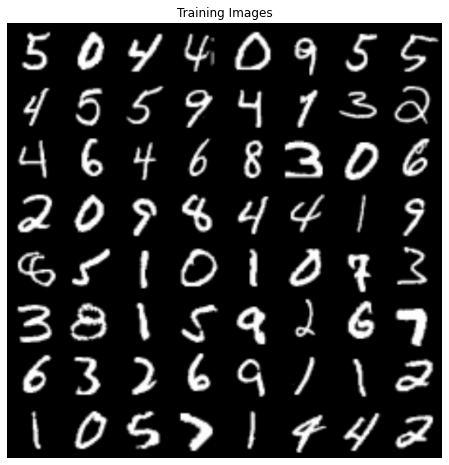

In [107]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [108]:
z = torch.randn(64, Z_DIM, 1, 1).to(device)

In [109]:
gen(z).shape

torch.Size([64, 1, 64, 64])

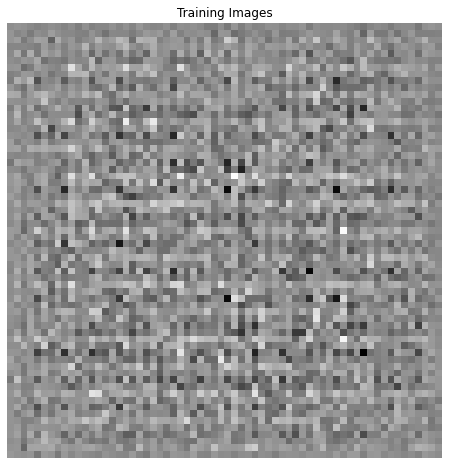

In [110]:

fake_batch = gen(z)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(fake_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

Epoch [0/5] Batch 0/469 \ Loss D: 0.7025, loss G: 0.4236
Epoch [0/5] Batch 100/469 \ Loss D: 0.0001, loss G: 0.0001
Epoch [0/5] Batch 200/469 \ Loss D: 0.0000, loss G: 0.0000
Epoch [0/5] Batch 300/469 \ Loss D: 0.0000, loss G: 0.0000
Epoch [0/5] Batch 400/469 \ Loss D: 0.0000, loss G: 0.0000
Epoch [1/5] Batch 0/469 \ Loss D: 0.0000, loss G: 0.0000
Epoch [1/5] Batch 100/469 \ Loss D: 0.0000, loss G: 0.0000
Epoch [1/5] Batch 200/469 \ Loss D: 0.0000, loss G: 0.0000


KeyboardInterrupt: ignored

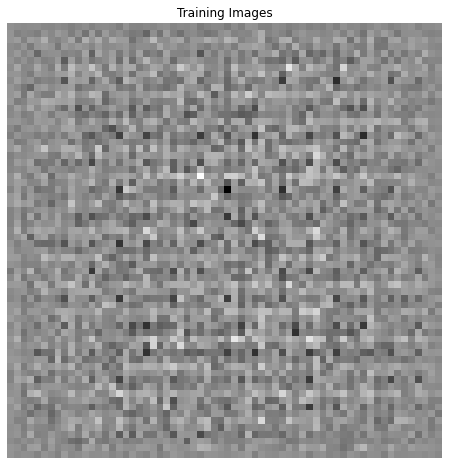

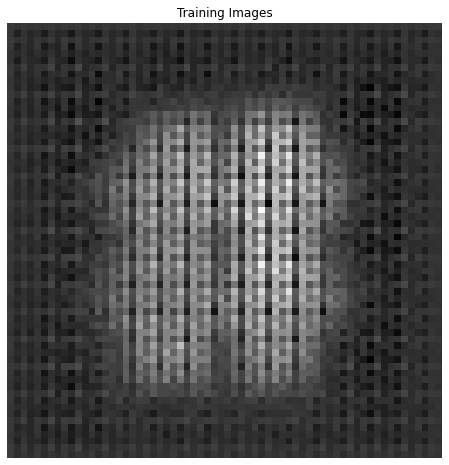

In [111]:
for epoch in range(NUM_EPOCHS):

  z_test = torch.randn(64, Z_DIM, 1, 1).to(device)
  fake_batch_test = gen(z_test)
  plt.figure(figsize=(8,8))
  plt.axis("off")
  plt.title("Training Images")
  plt.imshow(np.transpose(vutils.make_grid(fake_batch_test[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

  for batch_index, (real, _) in enumerate(dataloader):
    real = real.to(device)
    z = torch.randn(BATCH_SIZE, Z_DIM, 1, 1).to(device)
    fake = gen(z)

    ###Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
    disc_real = disc(real).reshape(-1)
    loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))

    disc_fake = disc(fake.detach()).reshape(-1)
    loss_disc_fake = criterion(disc_fake, torch.ones_like(disc_fake))

    loss_disc = (loss_disc_real + loss_disc_fake) / 2

    disc.zero_grad()
    loss_disc.backward()
    opt_disc.step()

    ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
    output = disc(fake).reshape(-1)
    loss_gen = criterion(output, torch.ones_like(output))

    gen.zero_grad()
    loss_gen.backward()
    opt_gen.step()

    if batch_index % 100 == 0:
      print(f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_index}/{len(dataloader)} \ Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}")

  #Plot some generated images at the end of each epoch
  